In [6]:
import os
import shutil
import random
from pathlib import Path

## Preprocessing

In [7]:
# Path asal folder
source_base = 'geometric_shapes_dataset'
target_base = 'dataset'
labels = ['Circle', 'Square', 'Triangle']

# Rasio split
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [8]:
# Buat struktur folder target
for split in ['train', 'val', 'test']:
    for label in labels:
        Path(f'{target_base}/{split}/{label.lower()}').mkdir(parents=True, exist_ok=True)

# Fungsi pembagi file gambar dari folder asal
def split_and_copy_from_subfolder(label):
    folder_path = os.path.join(source_base, label)
    all_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_files)

    total = len(all_files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    splits = {
        'train': all_files[:train_end],
        'val': all_files[train_end:val_end],
        'test': all_files[val_end:]
    }

    for split, files in splits.items():
        for f in files:
            src_path = os.path.join(folder_path, f)
            dst_path = os.path.join(target_base, split, label.lower(), f)
            shutil.copy(src_path, dst_path)

# Jalankan pembagian untuk tiap label
for label in labels:
    split_and_copy_from_subfolder(label)

print("Dataset berhasil dibagi ke folder train/val/test.")

Dataset berhasil dibagi ke folder train/val/test.


## CNN

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
# Folder dataset
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

# Preprocessing & Augmentasi data
img_size = (64, 64)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, class_mode='categorical', batch_size=batch_size)
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 27300 images belonging to 3 classes.
Found 10802 images belonging to 3 classes.
Found 5696 images belonging to 3 classes.


In [4]:
# Arsitektur CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Callback Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# Evaluasi
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 148s 170ms/step - accuracy: 0.3310 - loss: 1.1260 - val_accuracy: 0.3343 - val_loss: 1.0987
Epoch 2/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 152s 178ms/step - accuracy: 0.3342 - loss: 1.0996 - val_accuracy: 0.3254 - val_loss: 1.0897
Epoch 3/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 133s 155ms/step - accuracy: 0.3649 - loss: 1.0854 - val_accuracy: 0.4623 - val_loss: 1.0225
Epoch 4/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 129s 151ms/step - accuracy: 0.4201 - loss: 1.0591 - val_accuracy: 0.4778 - val_loss: 0.9837
Epoch 5/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 141s 165ms/step - accuracy: 0.4581 - loss: 1.0160 - val_accuracy: 0.5790 - val_loss: 0.8747
Epoch 6/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 134s 157ms/step - accuracy: 0.5141 - loss: 0.9444 - val_accuracy: 0.6459 - val_loss: 0.7707
Epoch 7/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 139s 163ms/step - accuracy: 0.5890 - loss: 0.8507 - val_accuracy: 0.7464 - val_loss: 0.6113
Epoch 8/30
854/854 ━━━━━━━━━━━━━━━━━━━━ 141s 165ms/step - accuracy: 0.6518 -

Analisis Overfitting / Underfitting
Underfitting? Tidak. Karena training accuracy cukup tinggi dan terus meningkat.

Overfitting? Tidak terlalu parah. Memang ada sedikit gap antara validation dan training, tapi masih dalam batas wajar.

Model ini umumnya generalisasi dengan baik pada data validasi.

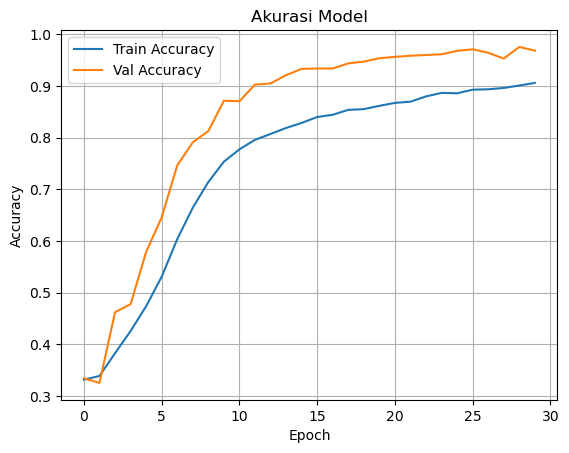

In [6]:
# Visualisasi akurasi dan loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Akurasi Model')
plt.grid(True)
plt.show()

1. Kenaikan Awal yang Cepat (Epoch 0–10):
   Ini menunjukkan bahwa model berhasil belajar fitur dasar dari bentuk-bentuk geometri.
2. Akurasi Model Stabil di Atas 90% Setelah Epoch ~15:
   
- Validation accuracy mendekati 99%, dan training accuracy mendekati 91%.

- Ini menunjukkan bahwa model telah mencapai konvergensi.

- Tidak ada penurunan tajam pada validation accuracy → tidak terjadi overfitting yang parah.

Kesimpulan	Model CNN sukses mempelajari bentuk geometri dan generalisasi dengan baik

In [8]:
model.save("model_geometric_shapes.h5")

## Prediksi

In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [18]:
# Load model
model = load_model("model_geometric_shapes.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Akurasi pada 9 gambar acak: 100.00%


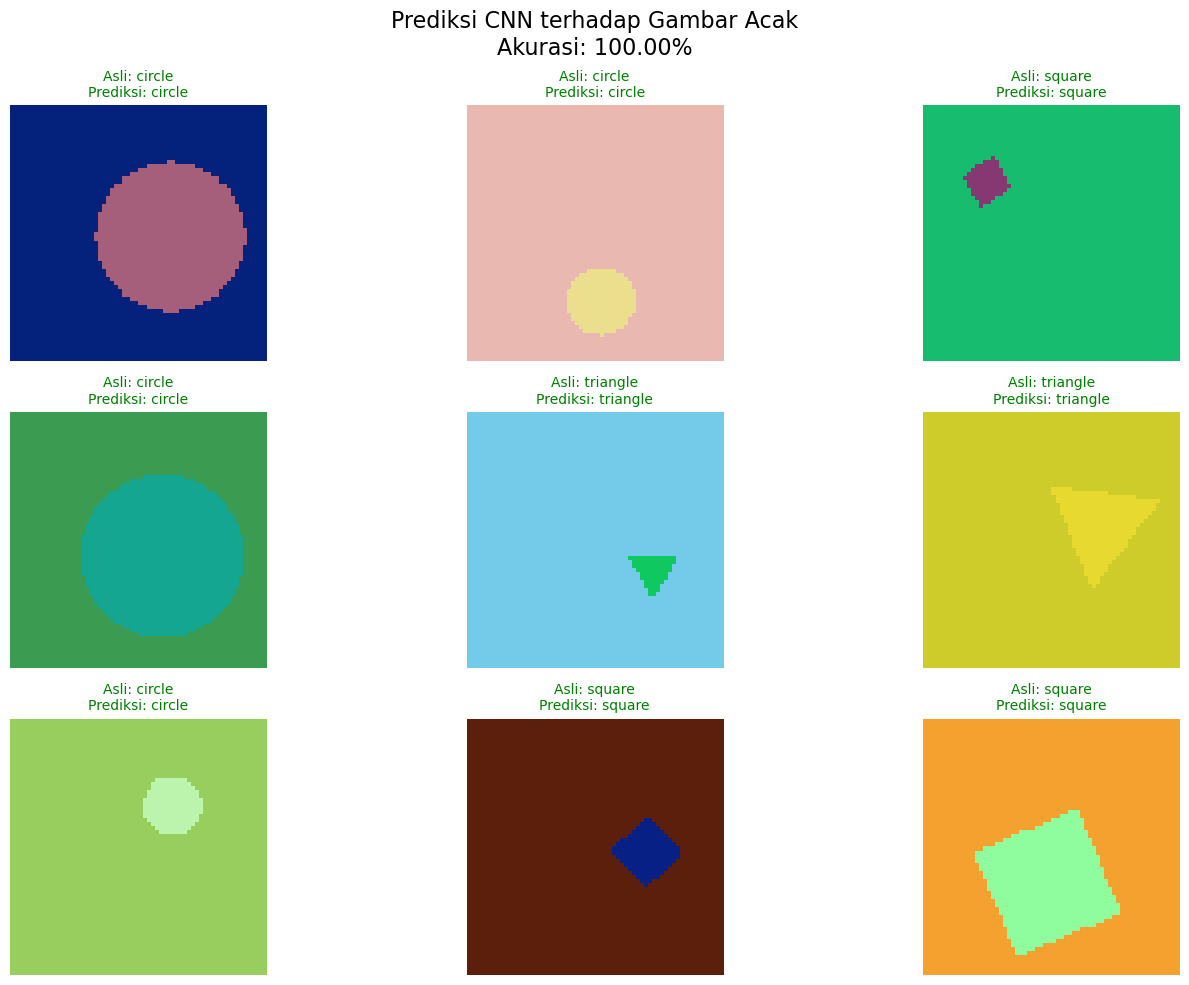

In [19]:
# Load model yang sudah dilatih
model = load_model("model_geometric_shapes.h5")

# Label class
class_labels = ['circle', 'square', 'triangle']

# Path test set
test_base_dir = 'dataset/test'

# Jumlah gambar yang ingin diuji
num_samples = 9

# List gambar acak (tuple: path, true_label)
image_paths = []
for _ in range(num_samples):
    true_label = random.choice(class_labels)
    img_name = random.choice(os.listdir(os.path.join(test_base_dir, true_label)))
    full_path = os.path.join(test_base_dir, true_label, img_name)
    image_paths.append((full_path, true_label))

# Plot dan evaluasi prediksi
correct = 0

plt.figure(figsize=(15, 10))
for idx, (img_path, true_label) in enumerate(image_paths):
    # Preprocessing gambar
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi
    pred = model.predict(img_array)
    predicted_label = class_labels[np.argmax(pred)]

    # Hitung prediksi benar
    if predicted_label == true_label:
        correct += 1

    # Visualisasi
    plt.subplot(3, 3, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Asli: {true_label}\nPrediksi: {predicted_label}",
        fontsize=10,
        color="green" if predicted_label == true_label else "red"
    )

# Akurasi
accuracy = correct / num_samples * 100
print(f"\nAkurasi pada {num_samples} gambar acak: {accuracy:.2f}%")

plt.suptitle("Prediksi CNN terhadap Gambar Acak\nAkurasi: {:.2f}%".format(accuracy), fontsize=16)
plt.tight_layout()
plt.show()

Kesimpulan:

Model memiliki performa sangat baik dalam mengenali bentuk geometri pada dataset yang terstruktur, ditunjukkan oleh akurasi prediksi 100% pada sampel acak. Hal ini mengindikasikan bahwa arsitektur model dan strategi pelatihan sudah cukup efektif dalam memahami representasi visual bentuk dasar.